In this notebook, I test out the linmix code for linear regression. This is a Python version of the Kelly 2007 method for linear regression. 


Link to repo: 
- https://github.com/jmeyers314/linmix

Docs:
- https://linmix.readthedocs.io/en/latest/index.html
- https://linmix.readthedocs.io/en/latest/example.html

Installation:
- https://linmix.readthedocs.io/en/latest/install.html

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import linmix
np.random.seed(500)
import matplotlib as mpl
import matplotlib.font_manager as font_manager
from IPython.display import display, clear_output

params = {'text.usetex':False, 'mathtext.fontset':'custom', 'mathtext.default':'regular'}
mpl.rcParams.update(params)

# Basic plotting settings
single_col = 8.9 # cm
double_col = 18.3 # cm
def cm2inch(value):
    return value/2.54
FS  = 20
LS  = 20
MS  = 10
MEW = 3

%matplotlib inline

---

# linmix Website Example

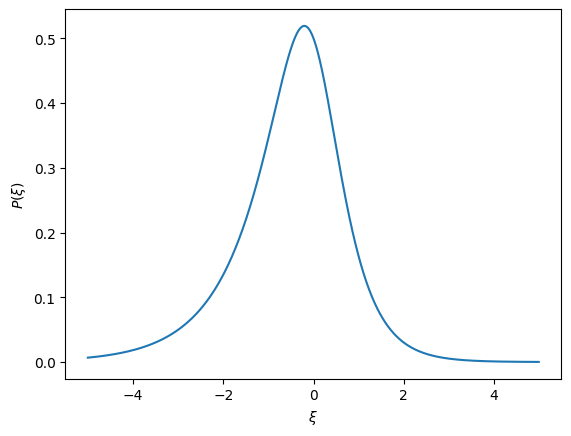

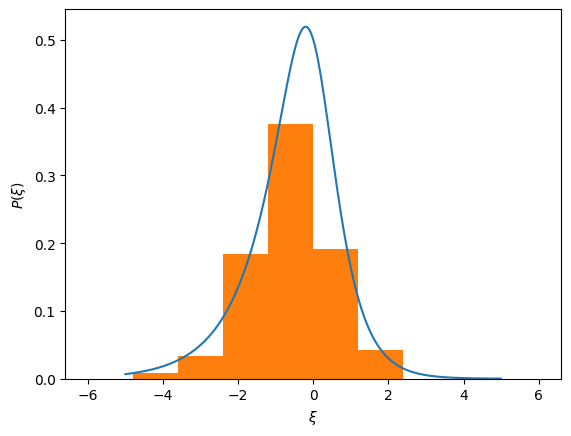

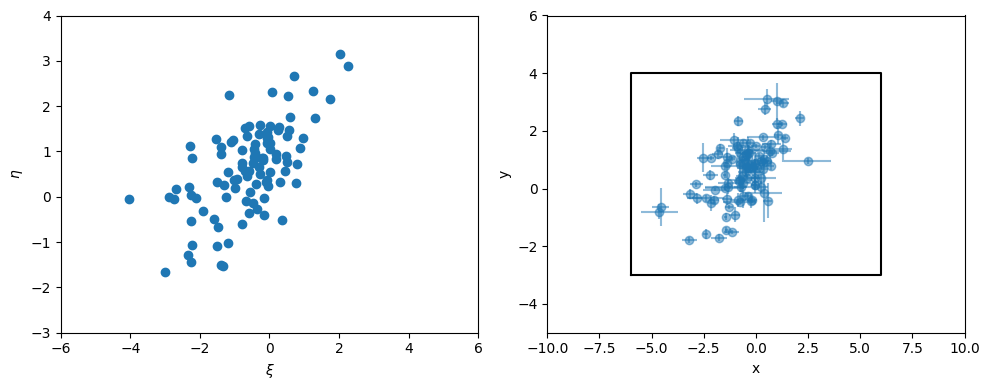

In [2]:
## Create example data

def pxi(xi):
    return np.exp(xi) * (1.0 + np.exp(2.75*xi))**(-1)
fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(-5,5, 0.01)
ax.plot(x, pxi(x))
ax.set_xlabel(r"$\xi$")
ax.set_ylabel(r"$P(\xi)$")
plt.show()

def rejection_sample(p, pmax, prop, size):
    out=[]
    for s in range(size):
        x = prop()
        px = p(x)
        pu = np.random.uniform(low=0.0, high=pmax)
        while px < pu:
            x = prop()
            px = p(x)
            pu = np.random.uniform(low=0.0, high=pmax)
        out.append(x)
    return np.array(out)
pmax = 0.55 # max p(xi) determined by eye
prop = lambda : np.random.uniform(low=-10, high=10) # truncating range to (-10, 10)
xi = rejection_sample(pxi, pmax, prop, size=100)

fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(-5,5, 0.01)
ax.plot(x, pxi(x))
ax.hist(xi, 10, range=(-6,6), density=True)
ax.set_xlabel(r"$\xi$")
ax.set_ylabel(r"$P(\xi)$")
plt.show()


# Set the regression parameters
alpha = 1.0
beta = 0.5
sigsqr = 0.75**2
epsilon = np.random.normal(loc=0, scale=np.sqrt(sigsqr), size=len(xi))
eta = alpha + beta*xi + epsilon

# Initialise uncorrelated 1-sigma errors
tau = np.std(xi)
sigma = np.sqrt(sigsqr)
t = 0.4 * tau
s = 0.5 * sigma
xsig = 5*t**2 / np.random.chisquare(5, size=len(xi))
ysig = 5*s**2 / np.random.chisquare(5, size=len(eta))
x = np.random.normal(loc=xi, scale=xsig)
y = np.random.normal(loc=eta, scale=ysig)

# Plot data
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
ax.scatter(xi, eta)
ax.set_xlabel(r'$\xi$')
ax.set_ylabel(r'$\eta$')
ax.set_xlim(-6,6)
ax.set_ylim(-3,4)
ax = fig.add_subplot(122)
ax.scatter(x, y, alpha=0.5)
ax.errorbar(x, y, xerr=xsig, yerr=ysig, ls=' ', alpha=0.5)
ax.set_xlabel(r'x')
ax.set_ylabel(r'y')
ax.set_xlim(-10,10)
ax.set_ylim(-5,6)
ax.plot([-6,6,6,-6,-6], [-3,-3,4,4,-3], color='k')
fig.tight_layout()
plt.show()

- The code below will run somewhere between 5000 and 100000 steps of a MCMC to produce samples from the posterior distribution of the model parameters, given the data.
- The code will automatically compare the variance of sample parameters between chains to the variance within single chains to determine if convergence has been reached and stop. 
- If we want to see status updates as the code runs, then set silent=False or just leave the silent keyword out completely (its default is False).
- K is the number of components in the mixture model 

In [3]:
# Run linmix algorithm on the simulated data
lm = linmix.LinMix(x, y, xsig, ysig, K=2)
lm.run_mcmc(silent=True)

- Plot the data and some samples from the Bayesian posterior on the same graph.
- The black line shows the input regression line and the red lines show some samples from the posterior distribution.

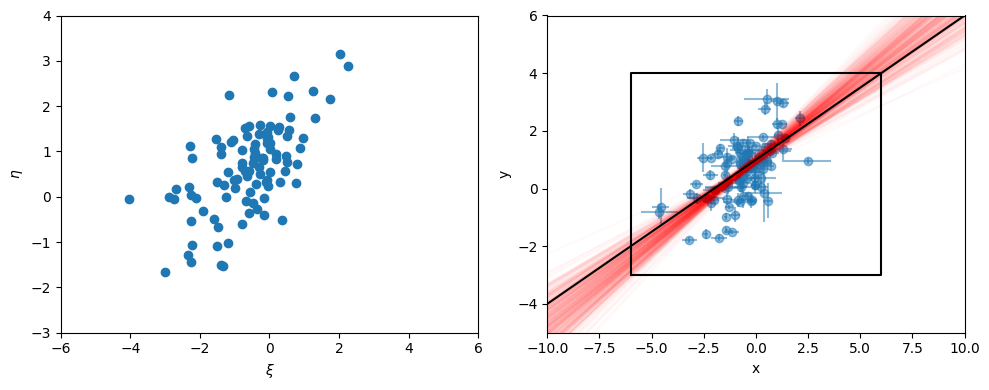

In [ ]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
ax.scatter(xi, eta)
ax.set_xlabel(r'$\xi$')
ax.set_ylabel(r'$\eta$')
ax.set_xlim(-6,6)
ax.set_ylim(-3,4)
ax = fig.add_subplot(122)
ax.scatter(x, y, alpha=0.5)
ax.errorbar(x, y, xerr=xsig, yerr=ysig, ls=' ', alpha=0.5)
# Plot sampled regression lines
for i in range(0, len(lm.chain), 25):
    xs = np.arange(-10,11)
    ys = lm.chain[i]['alpha'] + xs * lm.chain[i]['beta']
    ax.plot(xs, ys, color='r', alpha=0.02)
# Plot true regression line
ys = alpha + xs * beta
ax.plot(xs, ys, color='k')
# Set plot labels and limits
ax.set_xlabel(r'x')
ax.set_ylabel(r'y')
ax.set_xlim(-10,10)
ax.set_ylim(-5,6)
ax.plot([-6,6,6,-6,-6], [-3,-3,4,4,-3], color='k')
fig.tight_layout()

Missing data:
- The delta array is used to indicate if a source is detected or not. 
- The downward pointing arrows to indicate the upper limits on the non-detections. 
- Again, the black line shows the input regression line, the red lines show samples from the posterior when no data is censored, and the green lines show samples from the posterior of the censored dataset. 
- Linmix still does a good job of estimating the parameters of this challenging data set, in which only 21 of 100 points are detected.

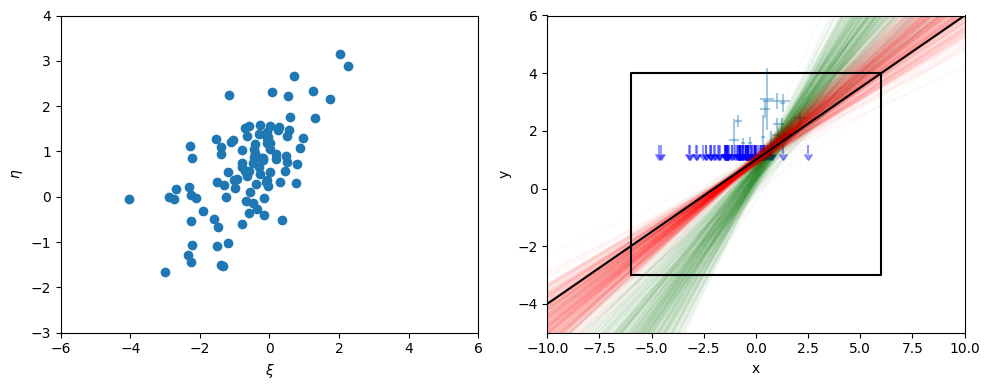

In [ ]:
delta = y > 1.5
notdelta = np.logical_not(delta)
ycens = y.copy()
ycens[notdelta] = 1.5
lmcens  = linmix.LinMix(x, ycens, xsig, ysig, delta=delta, K=2)
lmcens.run_mcmc(silent=True)


## Plot the results
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
ax.scatter(xi, eta)
ax.set_xlabel(r'$\xi$')
ax.set_ylabel(r'$\eta$')
ax.set_xlim(-6,6)
ax.set_ylim(-3,4)
ax = fig.add_subplot(122)
# Plot the data
ax.errorbar(x[delta], ycens[delta], xsig[delta], ysig[delta], ls=' ', alpha=0.4)
ax.errorbar(x[notdelta], ycens[notdelta], yerr=0.3, uplims=np.ones(sum(notdelta), dtype=bool), ls=' ', c='b', alpha=0.4)
# Plot sampled regression lines when censoring is included
for i in range(0, len(lmcens.chain), 25):
    xs = np.arange(-10, 11)
    ys = lmcens.chain[i]['alpha'] + xs * lmcens.chain[i]['beta']
    ax.plot(xs, ys, color='g', alpha=0.02)
# Plot sampled regression lines without censoring
for i in range(0, len(lm.chain), 25):
    xs = np.arange(-10, 11)
    ys = lm.chain[i]['alpha'] + xs * lm.chain[i]['beta']
    ax.plot(xs, ys, color='r', alpha=0.02)
# Plot true regression line
ys = alpha + xs * beta
ax.plot(xs, ys, color='k')
# Set plot labels and limits
ax.set_xlabel(r'x')
ax.set_ylabel(r'y')
ax.set_xlim(-10,10)
ax.set_ylim(-5,6)
ax.plot([-6,6,6,-6,-6], [-3,-3,4,4,-3], color='k')
fig.tight_layout()
plt.show()

---

# linmix van den Eijnden+ 2022 Example

van den Eijnden+ 2022 use linmix in the context of the radio:X-ray plane. They conduct repeats, each time resampling the distance for their source. 

Example where they use the package:
- https://github.com/jvandeneijnden/MeerKATCampaignOfCenXm4/blob/main/Reproduction_Notebook_Python2.ipynb

See also:
- https://ui.adsabs.harvard.edu/abs/2022MNRAS.516.4844V/abstract
- https://github.com/jvandeneijnden/LxLrCouplingInBeXRBs/blob/main/Transient%20BeXRB%20radio%20monitoring%20-%20Reproduction%20Notebook.ipynb

In [7]:
## The assumed distance to the source:
D_CenX4 = 1.2
dD_CenX4 = 0.3


## Defining a function that can plot histograms using the output of np.histogram and a defined axis:

def hist_plotter(ax, edges, counts, C='k', LW=2, normalized_to_one=True, label='', ALPHA=1.0):
    
    if normalized_to_one:
        counts = counts/float(max(counts))
    
    ax.plot([edges[0]]*2, [0, counts[0]], lw=LW, color=C, label=label, alpha=ALPHA)
    ax.plot([edges[-1]]*2, [counts[-1], 0], lw=LW, color=C, alpha=ALPHA)
    for i in range(len(edges)-1):
        ax.plot([edges[i], edges[i+1]], [counts[i]]*2, lw=LW, color=C, alpha=ALPHA)
        if i != 0:
            ax.plot([edges[i]]*2, [counts[i-1],counts[i]], lw=LW, color=C, alpha=ALPHA)
            
    return


## The data: Lx and Lr, with errors, and then converted to log scale:

# Order: 
# [0] == Tudor et al. 2017 deep limit
# [1:5] == the new data from Van den Eijnden et al. 2022
# [5:] == the archival radio detections as presented in Tudor et al. 2017
lx = np.asarray([1.458e+31, 6.0e31, 1.3e33, 5.5e32, 3.5e32, 7.64e+36, 5.52e+36, 2.76e+36, 3.46e+36, 1.08e+36, 1.08e+36])
dlx = np.asarray([9.e+30, 1.7e31, 0.3e33, 0.4e32, 0.9e32, 6.38e+35, 4.55e+35, 5.23e+35, 5.92e+35, 3.69e+35, 3.69e+35])
lr = np.asarray([1.21e+26, 1.1e26, 5.9e26, 4.7e26, 4.1e26, 2.94e+28, 4.84e+28, 6.91e+28, 6.13e+28, 4.32e+28, 1.73e+28])
dlr = np.asarray([0.333*1.21e+26, 0.333*1.1e26, 0.333*5.9e26, 0.333*4.7e26, 0.333*4.1e26, 1.38e+28, 1.38e+28, 2.16e+28, 2.85e+28, 2.16e+28, 8.64e+27])

# 0 == radio non-detection, 1 == radio detection
delta = np.asarray([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1])


# The anchors in X-ray and radio luminosity
lx0 = 2.00e36
lr0 = 3.72e28

lx_scaled = lx/lx0
dlx_scaled_p = (lx+dlx)/lx0
dlx_scaled_m = (lx-dlx)/lx0

log_lx_scaled = np.log10(lx_scaled) # x
log_dlx_scaled_p = np.log10(dlx_scaled_p)
log_dlx_scaled_m = np.log10(dlx_scaled_m)
log_dlx_scaled = (log_dlx_scaled_p - log_dlx_scaled_m)/2.

lr_scaled = lr/lr0
dlr_scaled_p = (lr+dlr)/lr0
dlr_scaled_m = (lr-dlr)/lr0

log_lr_scaled = np.log10(lr_scaled) # y
log_dlr_scaled_p = np.log10(dlr_scaled_p)
log_dlr_scaled_m = np.log10(dlr_scaled_m)
log_dlr_scaled = (log_dlr_scaled_p - log_dlr_scaled_m)/2.

In [ ]:
# Run linmix ONCE
# Note: The results differ every time this is run

lm = linmix.LinMix(x=log_lx_scaled, y=log_lr_scaled, xsig=log_dlx_scaled, ysig=log_dlr_scaled, delta=delta,K=3)
lm.run_mcmc(miniter=5000,maxiter=5000,silent=True)

-0.19047073072561943 0.2957681861252062 0.2370726860886089
1.3250571189555536 0.49607005157391193 0.5004473107938301
0.753459605731457


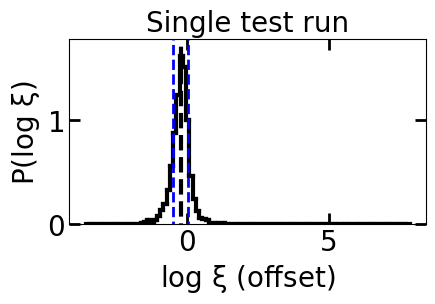

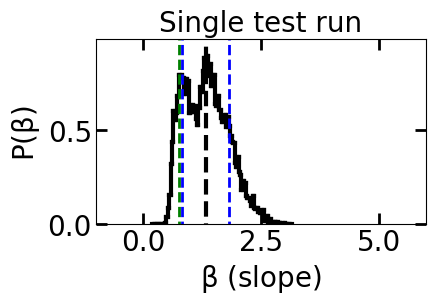

In [14]:
## Extract the fitted parameters for Alpha* (== Xi in the paper), Beta, and Sigma
# * Here, we use alpha to stick to the nomenclature of the linmix documentation

alphas = []
betas = []
sigmas = []
for i in range(len(lm.chain)):
    alphas.append(lm.chain[i]['alpha']) # c, i.e. intercept log(Xi)
    betas.append(lm.chain[i]['beta']) # m, i.e. slope beta
    sigmas.append(lm.chain[i]['sigsqr']) # "spread" of data around best-fit
    
# Calculating the percentiles:
alpha_16 = np.percentile(alphas,16)
alpha_50 = np.percentile(alphas,50)
alpha_84 = np.percentile(alphas,84)
alpha_mean = np.mean(alphas)

beta_10 = np.percentile(betas,10)
beta_16 = np.percentile(betas,16)
beta_50 = np.percentile(betas,50)
beta_84 = np.percentile(betas,84)
beta_mean = np.mean(betas)
    
# Creating histograms:    
alpha_counts, alpha_edges = np.histogram(alphas, bins=100, density=True)
beta_counts, beta_edges = np.histogram(betas, bins=100, density=True)
sigma_counts, sigma_edges = np.histogram(sigmas, bins=500, range=[0,2], density=True)

# Printing the percentiles for offset and slope
print(alpha_50, alpha_50-alpha_16, alpha_84-alpha_50)
print(beta_50, beta_50-beta_16, beta_84-beta_50)
print(beta_10)


###############################################################################################################
## Plotting the outcome of this single run for eta:

fig = plt.figure(figsize=(cm2inch(12.),cm2inch(8.)))
ax = fig.add_subplot(111)
hist_plotter(ax=ax, edges=alpha_edges, counts=alpha_counts, LW=3, normalized_to_one=False)
ax.plot([alpha_16,alpha_16], [-1,1000], 'b--', lw=2)
ax.plot([alpha_84,alpha_84], [-1,1000], 'b--', lw=2)
ax.plot([alpha_mean,alpha_mean], [-1,1000], 'k--', lw=3)
ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=3)
ax.tick_params(labelsize=LS, length=4, width=1, axis='both', which='minor', pad=3)
ax.set_ylim(0, 1.1*max(alpha_counts))
ax.set_xlabel(r'log $\xi$ (offset)', fontsize=FS)
ax.set_ylabel(r'P(log $\xi$)', fontsize=FS)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')
ax.set_title('Single test run', fontsize=FS)
plt.tight_layout()
plt.show()

###############################################################################################################
## Plotting the outcome of this single test run for beta:

fig = plt.figure(figsize=(cm2inch(12.),cm2inch(8)))
ax = fig.add_subplot(111)
hist_plotter(ax=ax, edges=beta_edges, counts=beta_counts, LW=3, normalized_to_one=False)
ax.plot([beta_16,beta_16], [-1,1000], 'b--', lw=2)
ax.plot([beta_84,beta_84], [-1,1000], 'b--', lw=2)
ax.plot([beta_10,beta_10], [-1,1000], 'g--', lw=2)
ax.plot([beta_mean,beta_mean], [-1,1000], 'k--', lw=3)
ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=3)
ax.tick_params(labelsize=LS, length=4, width=1, axis='both', which='minor', pad=3)
ax.set_ylim(0, 1.1*max(beta_counts))
ax.set_xlim(-1,6)
ax.set_xlabel(r'$\beta$ (slope)', fontsize=FS)
ax.set_ylabel(r'$P(\beta)$', fontsize=FS)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')
ax.set_title('Single test run', fontsize=FS)
plt.tight_layout()
plt.show()

###############################################################################################################

Now, for the full fit, we repeat the linmix fit 100 times, each time varying the distance in a Gaussian around the mean value. Thereby, we fold in the uncertainty on the distance into those on the fitted parameters.

In [15]:
## Do N_runs:

N_runs = 100

all_alphas = []
all_betas = []
all_sigmas = []

alpha_16 = []
alpha_50 = []
alpha_84 = []
alpha_mean = []

beta_10 = []
beta_16 = []
beta_50 = []
beta_84 = []
beta_mean = []

sigma_16 = []
sigma_50 = []
sigma_84 = []
sigma_mean = []

for j in range(N_runs):
    clear_output(wait=True)
    display('Iteration '+str(j+1)+' Percentage: '+str((float(j+1)/N_runs)*100.0)+'%')
    
    # Apply a correction on the luminosities due to distance, in log space:
    # Each time, re-draw the assumed distance 
    # Then scale the fitted luminosities by a factor (Di/D)^2 for iteration i... which means adding 2*log(Di/D) in log space
    # If the original value is x, then log(x*(Di/D)^2) = log(x) + log((Di/D)^2) = log(x) + 2*log(Di/D)
    X_CenX4 = np.random.normal(loc=D_CenX4, scale=dD_CenX4, size=1)[0]/D_CenX4 # scaling factor for luminosity
    X_array = np.asarray([X_CenX4]*11)
    d_corr = 2.*np.log10(X_array)
    
    # Run the MCMC
    lm = linmix.LinMix(x=log_lx_scaled+d_corr, y=log_lr_scaled+d_corr, xsig=log_dlx_scaled, ysig=log_dlr_scaled, delta=delta, K=3)
    lm.run_mcmc(miniter=5000,maxiter=5000,silent=True)
    
    # Extract the fitted parameters
    alphas = []
    betas = []
    sigmas = []
    for i in range(len(lm.chain)):
        alphas.append(lm.chain[i]['alpha'])
        betas.append(lm.chain[i]['beta'])
        sigmas.append(lm.chain[i]['sigsqr'])
    all_alphas = all_alphas + alphas
    all_betas = all_betas + betas
    all_sigmas = all_sigmas + sigmas

    # Calculating the percentiles, modes, and means:
    alpha_16.append(np.percentile(alphas,16))
    alpha_50.append(np.percentile(alphas,50)) # median
    alpha_84.append(np.percentile(alphas,84))
    alpha_mean.append(np.mean(alphas))

    beta_10.append(np.percentile(betas,10))
    beta_16.append(np.percentile(betas,16))
    beta_50.append(np.percentile(betas,50))
    beta_84.append(np.percentile(betas,84))
    beta_mean.append(np.mean(betas))

    sigma_16.append(np.percentile(sigmas,16))
    sigma_50.append(np.percentile(sigmas,50))
    sigma_84.append(np.percentile(sigmas,84))
    sigma_mean.append(np.mean(sigmas))

    # Create histograms
    alpha_counts, alpha_edges = np.histogram(alphas, bins=200, density=True)
    beta_counts, beta_edges = np.histogram(betas, bins=200, density=True)
    sigma_counts, sigma_edges = np.histogram(sigmas, bins=500, range=[0,2], density=True)
        

'Iteration 100 Percentage: 100.0%'

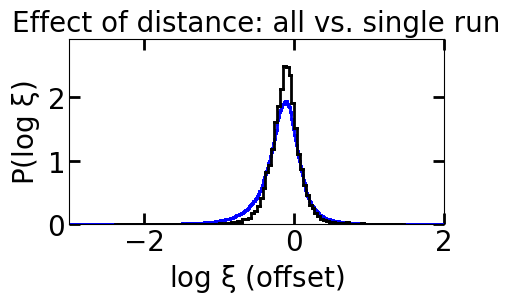

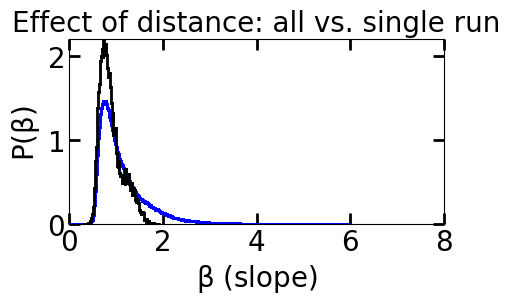

In [17]:
## Plot a comparison between one single run of linmix and the combined output of all linmix runs. 
# This will highlight if there is a systematic bias introduced by the assumed distance in a single run.
# From the results below, we conclude that, while there is a clear effect of including more runs in terms of the smoothness of the distributions, 
# we do not observe a systematic bias in the measured parameters.


# Defining a histogram of all alpha and beta values from all runs:
all_alpha_counts, all_alpha_edges = np.histogram(all_alphas, bins=1000, density=True)
all_beta_counts, all_beta_edges = np.histogram(all_betas, bins=1000, density=True)

# Also loading data for the last of the 100 runs for comparison:
onerun_alpha_counts, onerun_alpha_edges = np.histogram(alphas, bins=100, density=True)
onerun_beta_counts, onerun_beta_edges = np.histogram(betas, bins=100, density=True)


## Eta:   

fig = plt.figure(figsize=(cm2inch(12.),cm2inch(8)))
ax = fig.add_subplot(111)
hist_plotter(ax=ax, edges=all_alpha_edges, counts=all_alpha_counts, LW=2, normalized_to_one=False, C='b')
hist_plotter(ax=ax, edges=onerun_alpha_edges, counts=onerun_alpha_counts, LW=2, normalized_to_one=False, C='k')
ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=3)
ax.tick_params(labelsize=LS, length=4, width=1, axis='both', which='minor', pad=3)
ax.set_ylim(0, 1.5*max(all_alpha_counts))
ax.set_xlim(-3,2)
ax.set_xlabel(r'log $\xi$ (offset)', fontsize=FS)
ax.set_ylabel(r'P(log $\xi$)', fontsize=FS)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')
ax.set_title(r'Effect of distance: all vs. single run', fontsize=FS)
plt.tight_layout()
plt.show()


## Beta:   

fig = plt.figure(figsize=(cm2inch(12.),cm2inch(8)))
ax = fig.add_subplot(111)
hist_plotter(ax=ax, edges=all_beta_edges, counts=all_beta_counts, LW=2, normalized_to_one=False, C='b')
hist_plotter(ax=ax, edges=onerun_beta_edges, counts=onerun_beta_counts, LW=2, normalized_to_one=False, C='k')
ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=3)
ax.tick_params(labelsize=LS, length=4, width=1, axis='both', which='minor', pad=3)  
ax.set_ylim(0, 1.5*max(all_beta_counts))
ax.set_xlim(0, 8)
ax.set_xlabel(r'$\beta$ (slope)', fontsize=FS)
ax.set_ylabel(r'$P(\beta)$', fontsize=FS)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')
ax.set_title(r'Effect of distance: all vs. single run', fontsize=FS)
plt.tight_layout()
plt.show()

In [20]:
## Extract the results

## By combining the results from all runs:
# all_alphas has shape N_runs*n_chains

print ("The fitted values and uncertainties based on the mean, 16th, and 84th percentile of all values")
print ('Alpha =', np.round(np.mean(all_alphas),3), ', -'+str(np.round(np.mean(all_alphas)-np.percentile(all_alphas,16),3)), '+'+str(np.round(np.percentile(all_alphas,84)-np.mean(all_alphas),3)) )
print ('Beta =', np.round(np.mean(all_betas),3), ', -'+str(np.round(np.mean(all_betas)-np.percentile(all_betas,16),3)), '+'+str(np.round(np.percentile(all_betas,84)-np.mean(all_betas),3)) )
print ('Sigma =', np.round(np.mean(all_sigmas),3), ', -'+str(np.round(np.mean(all_sigmas)-np.percentile(all_sigmas,16),3)), '+'+str(np.round(np.percentile(all_sigmas,84)-np.mean(all_sigmas),3)) )
print ('')
print ("The fitted values and uncertainties based on the median, 16th, and 84th percentile of all values" )
print ('Alpha =', np.round(np.percentile(all_alphas,50),3), ', -'+str(np.round(np.percentile(all_alphas,50)-np.percentile(all_alphas,16),3)), '+'+str(np.round(np.percentile(all_alphas,84)-np.percentile(all_alphas,50),3)) )
print ('Beta =', np.round(np.percentile(all_betas,50),3), ', -'+str(np.round(np.percentile(all_betas,50)-np.percentile(all_betas,16),3)), '+'+str(np.round(np.percentile(all_betas,84)-np.percentile(all_betas,50),3)) )
print ('Sigma =', np.round(np.percentile(all_sigmas,50),3), ', -'+str(np.round(np.percentile(all_sigmas,50)-np.percentile(all_sigmas,16),3)), '+'+str(np.round(np.percentile(all_sigmas,84)-np.percentile(all_sigmas,50),3)) )
print ('')
print ("The 90% lower limit on beta from all values")
print ("Beta > ", np.round(np.percentile(all_betas,10),3))

print ("--------------------------------------------------------------------------------------------")
print ("--------------------------------------------------------------------------------------------")

###############################################################################################################

## By instead using the mean values of the median, 16th, and 84th percentile calculated from each individual run. 

print( "The fitted values based on the mean of the median, 16th, and 84th percentile of the 100 runs")
print( 'Alpha =', np.round(np.mean(alpha_50),3), '+'+str(np.round(np.mean(alpha_84)-np.mean(alpha_50),3)), str(np.round(np.mean(alpha_16)-np.mean(alpha_50),3)) )
print( 'Beta =', np.round(np.mean(beta_50),3), '+'+str(np.round(np.mean(beta_84)-np.mean(beta_50),3)), str(np.round(np.mean(beta_16)-np.mean(beta_50),3)) )
print()
print ("The 90% lower limit on beta from all values")
print ('Beta >', np.round(np.mean(beta_10),2), 'at 90% confidence level')



The fitted values and uncertainties based on the mean, 16th, and 84th percentile of all values
Alpha = -0.166 , -0.234 +0.233
Beta = 1.122 , -0.422 +0.436
Sigma = 0.524 , -0.472 +0.246

The fitted values and uncertainties based on the median, 16th, and 84th percentile of all values
Alpha = -0.142 , -0.258 +0.209
Beta = 0.96 , -0.259 +0.599
Sigma = 0.198 , -0.146 +0.572

The 90% lower limit on beta from all values
Beta >  0.656
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------
The fitted values based on the mean of the median, 16th, and 84th percentile of the 100 runs
Alpha = -0.144 +0.214 -0.265
Beta = 1.002 +0.601 -0.288

The 90% lower limit on beta from all values
Beta > 0.67 at 90% confidence level


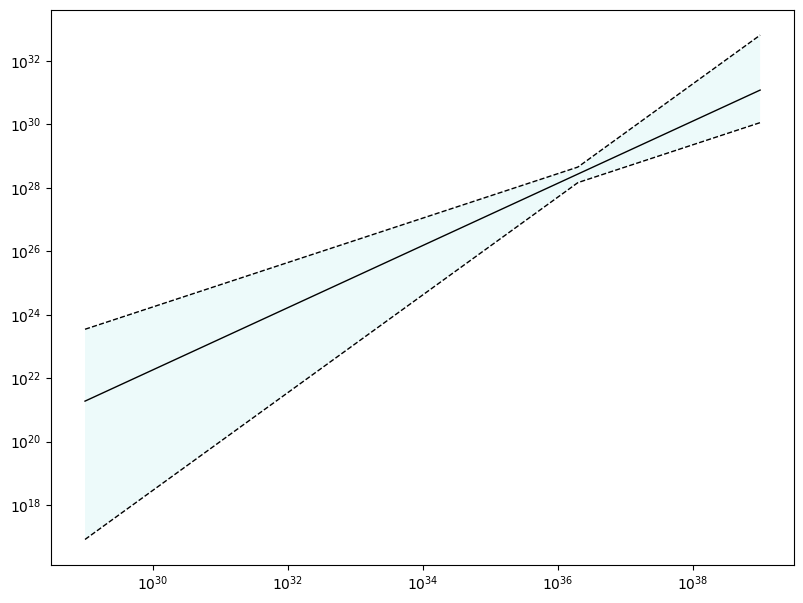

In [21]:
## Final plot

fig = plt.figure(figsize=(1.33*cm2inch(double_col), cm2inch(double_col)))
ax = fig.add_subplot(111)

# Plotting the fit:
log_model_axis = np.linspace(29,39,1000,endpoint=True)
model_axis = 10.0**log_model_axis

lx0 = 2.00e36
lr0 = 3.72e28

beta = 0.98
dbeta_l = 0.28
dbeta_u = 0.56
alpha = -0.14
dalpha_l = 0.27
dalpha_u = 0.22

# The four combinations of the two 1-sigma limits on slope and normalizations:
case1 = lr0 * ((model_axis/lx0)**(beta-dbeta_l)) * (10**(alpha +dalpha_u))
case2 = lr0 * ((model_axis/lx0)**(beta+dbeta_u)) * (10**(alpha -dalpha_l))
case3 = lr0 * ((model_axis/lx0)**(beta-dbeta_l)) * (10**(alpha -dalpha_l))
case4 = lr0 * ((model_axis/lx0)**(beta+dbeta_u)) * (10**(alpha +dalpha_u))
maxline = []
minline = []
for i in range(len(case1)):
    maxline.append(max(case1[i], case2[i], case3[i], case4[i]))
    minline.append(min(case1[i], case2[i], case3[i], case4[i]))
# The best fit:
casefit = lr0 * ((model_axis/lx0)**(beta)) * (10**(alpha))

# Actually plotting the lines:
ax.fill_between(model_axis, minline, maxline, facecolor='c', alpha=0.07)
newfitrange = ax.errorbar(model_axis, minline, fmt='k--', lw=1, label=r'$1$-$\sigma$ contours (all Cen X-4 data)')
ax.plot(model_axis, maxline, 'k--', lw=1)
newfit = ax.errorbar(model_axis, casefit, fmt='k-', lw=1, label=r'Best fit (all Cen X-4 data): $\beta = 0.98$')

ax.set_xscale('log')
ax.set_yscale('log')

plt.show()